In [1]:
import sys

# adapt paths
sys.path.append("/home/cctrotte/krauthammer/stcs_code/pysurvival_mine/")

In [2]:
#### 1 - Importing packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pysurvival_mine.models.simulations import SimulationModel
from pysurvival_mine.models.multi_task_mine import LinearMultiTaskModelMine,NeuralMultiTaskModelMine
from pysurvival_mine.utils.metrics import concordance_index
from pysurvival_mine.utils.display import integrated_brier_score
#%matplotlib inline  # To use with Jupyter notebooks


#### 2 - Generating the dataset from a Weibull parametric model
# Initializing the simulation model
sim = SimulationModel( survival_distribution = 'Weibull',
                       risk_type = 'linear',
                       censored_parameter = 10.0,
                       alpha = .01, beta = 3.0 )

# Generating N random samples 
N = 1000
dataset = sim.generate_data(num_samples = N, num_features = 3)

# Showing a few data-points 
time_column = 'time'
event_column = 'event'
dataset.head(2)

Number of data-points: 1000 - Number of events: 828.0


,x_1,x_2,x_3,time,event
0,0.539041,126.0,2.775725,3.670677,1.0
1,3.907159,118.0,-0.654105,7.168336,1.0


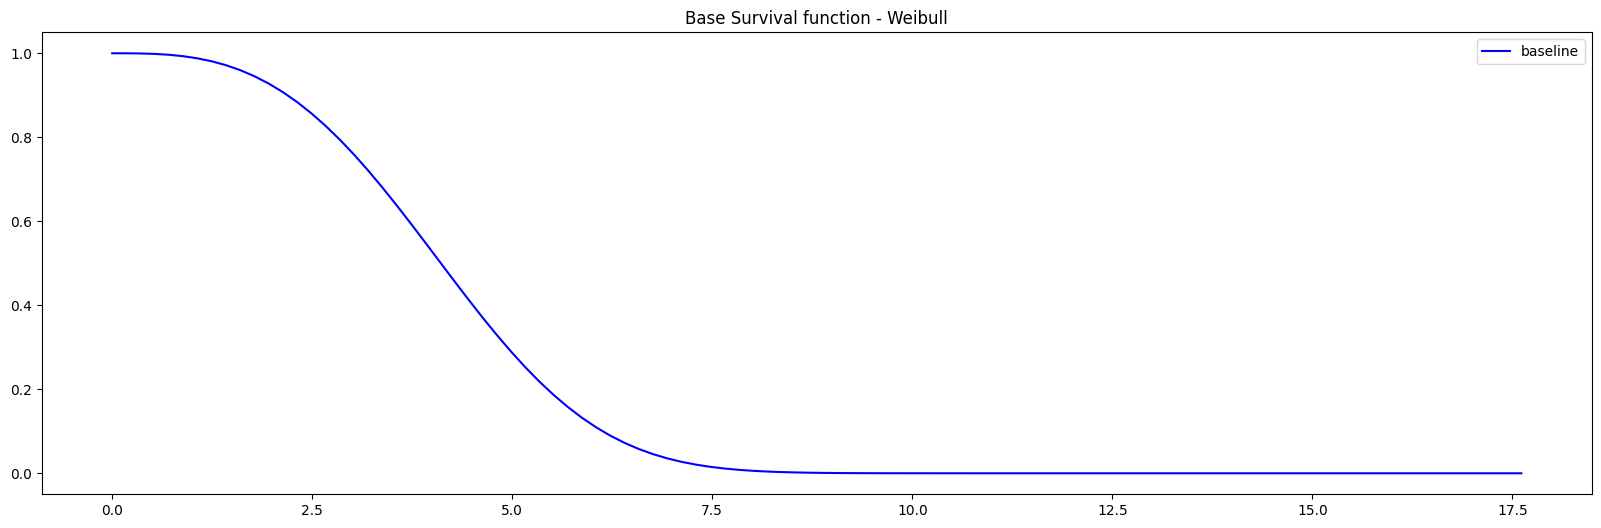

In [3]:
from pysurvival_mine.utils.display import display_baseline_simulations
display_baseline_simulations(sim, figure_size=(20, 6))

% Completion: 100%||The gradient exploded... You should reduce the learningrate (lr) of your optimizer


C-index: 0.80


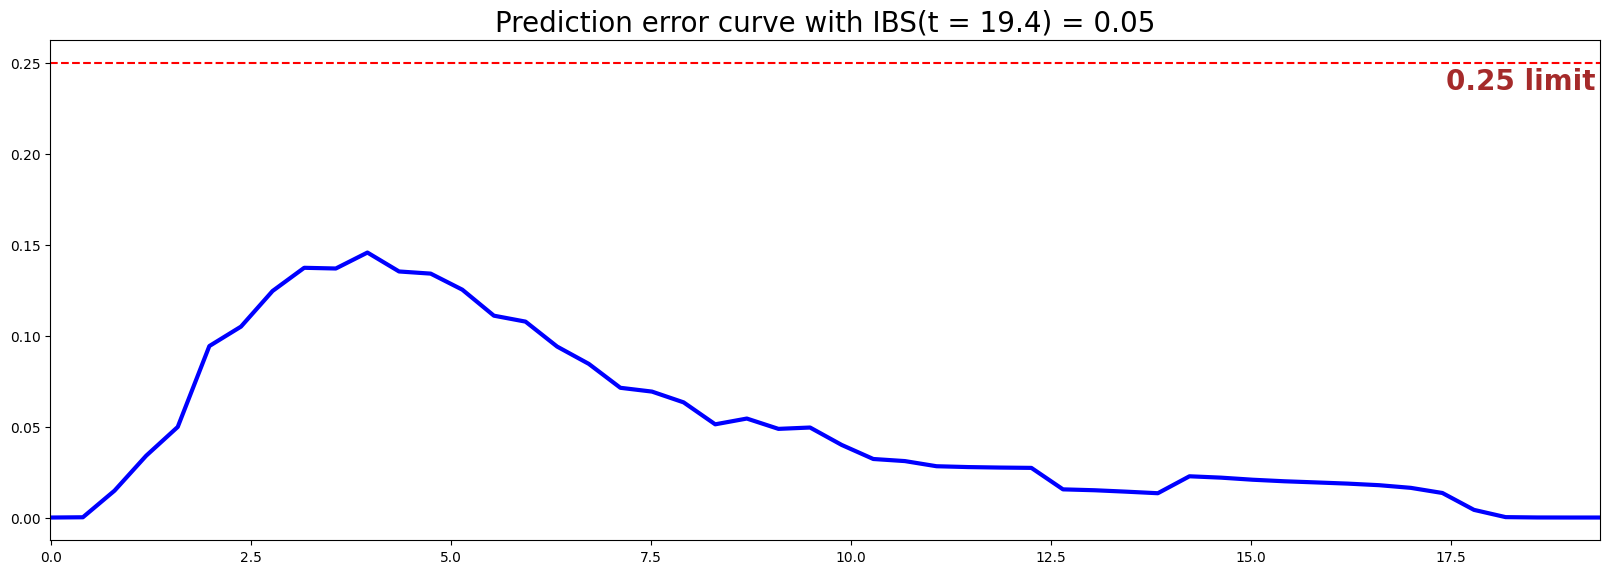

IBS: 0.05


In [4]:
#### 3 - Creating the modeling dataset
# Defining the features
features = sim.features

# Building training and testing sets #
index_train, index_test = train_test_split( range(N), test_size = 0.2)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )

# Creating the X, T and E input
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train['time'].values, data_test['time'].values
E_train, E_test = data_train['event'].values, data_test['event'].values
X_valid, T_valid, E_valid = X_test, T_test, E_test

#### 4 - Creating an instance of the NonLinear CoxPH model and fitting 
# the data.

# Defining the MLP structure. Here we will build a 1-hidden layer 
# with 150 units and `BentIdentity` as its activation function
structure = [ {'activation': 'BentIdentity', 'num_units': 150},  ]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
#### 4 - Creating an instance of the Linear MTLR model and fitting the data.
# Building the model
structure = [ {'activation': 'ReLU', 'num_units': 150},  ]
l_mtlr = NeuralMultiTaskModelMine(bins=50, auto_scaler = False, structure = structure)
l_mtlr.fit(X_train, T_train, E_train, X_valid, T_valid, E_valid, lr=1e-3, init_method='orthogonal')


#### 5 - Cross Validation / Model Performances
c_index = concordance_index(l_mtlr, X_test, T_test, E_test) #0.95
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(l_mtlr, X_test, T_test, E_test, t_max=30,
            figure_size=(20, 6.5) )
print('IBS: {:.2f}'.format(ibs))

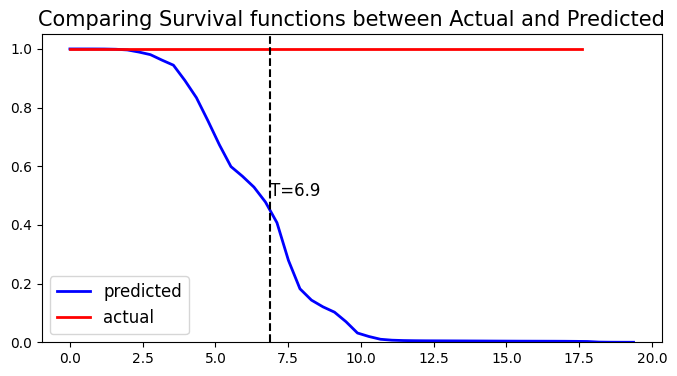

In [5]:
#### 6 - Comparing actual and predictions
# Initializing the figure
fig, ax = plt.subplots(figsize=(8, 4))

# Randomly extracting a data-point that experienced an event 
choices = np.argwhere((E_test==1.)&(T_test>=1)).flatten()
k = np.random.choice( choices, 1)[0]

# Saving the time of event
t = T_test[k]

# Computing the Survival function for all times t
predicted = l_mtlr.predict_survival(X_test[k, :]).flatten()
actual = sim.predict_survival(X_test[k, :]).flatten()

# Displaying the functions
plt.plot(l_mtlr.times, predicted, color='blue', label='predicted', lw=2)
plt.plot(sim.times, actual, color = 'red', label='actual', lw=2)

# Actual time
plt.axvline(x=t, color='black', ls ='--')
ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5), xytext=(t, 0.5), fontsize=12)

# Show everything
title = "Comparing Survival functions between Actual and Predicted"
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()

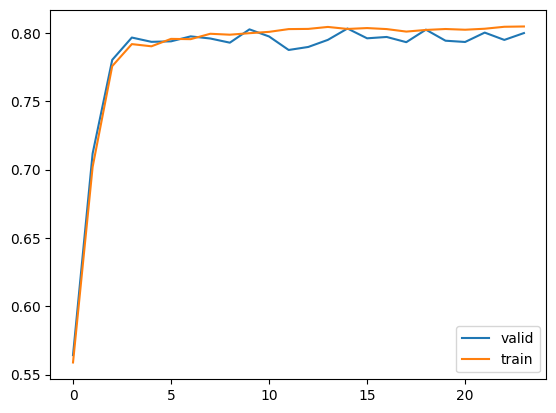

In [6]:
plt.figure()
plt.plot(l_mtlr.metrics["c_index_valid"], label = "valid")
plt.plot(l_mtlr.metrics["c_index_train"], label = "train")
plt.legend()

In [7]:
from pysurvival_mine.utils.display import compare_to_actual

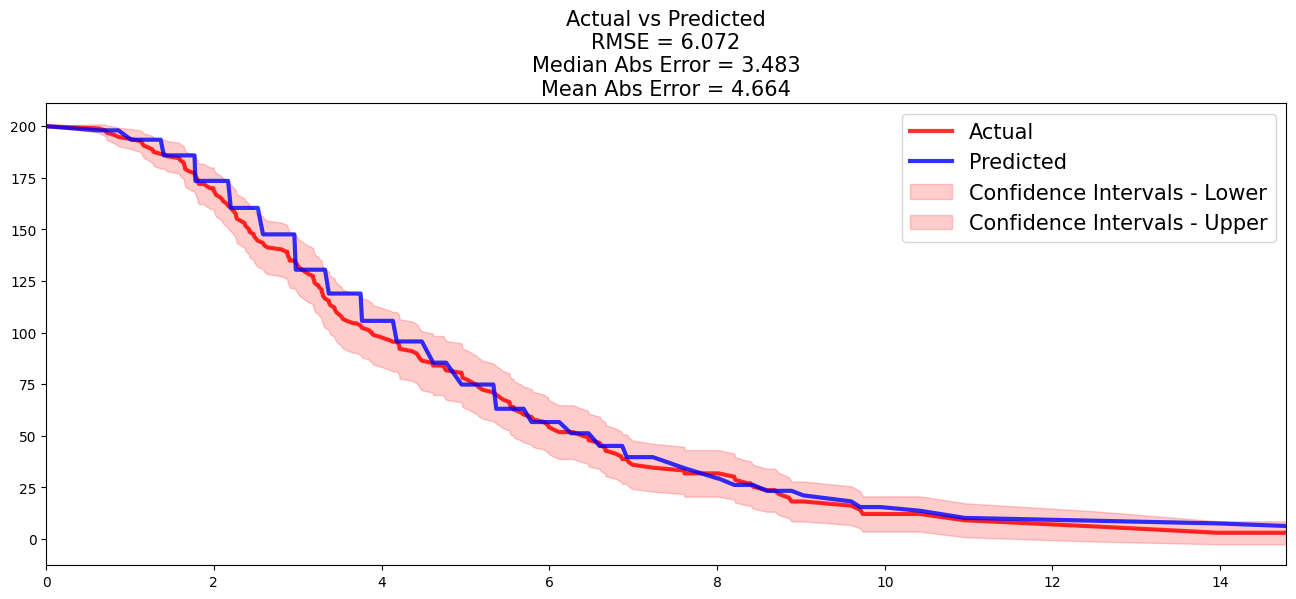

{'root_mean_squared_error': 6.072485881166903,
 'median_absolute_error': 3.483329013349902,
 'mean_absolute_error': 4.664068670331035}

In [8]:
compare_to_actual(l_mtlr, X_test, T_test, E_test,
                            is_at_risk = True,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])